In [31]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from scipy.io import loadmat
from scipy.interpolate import CubicSpline
rng_seed = 123
rng = np.random.default_rng(123)

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = f'../../data/hnn_beta'


In [32]:
def get_mean_beta_event(subj_waveforms, lower, upper, zero_idx, real_times, sim_times):
    event_mask = np.logical_and(waveforms[0][:,zero_idx] > lower, waveforms[0][:,zero_idx] < upper)
    print(f'{np.sum(event_mask)} events averaged')
    mean_event = np.mean(waveforms[0][event_mask, :], axis=0)
    
    cs = CubicSpline(real_times, mean_event)
    interp_event = cs(sim_times)
    
    return interp_event.reshape(1, -1)

In [33]:
def hnn_beta_param_function(net, theta_dict, rng=rng):
    beta_start = 200.0
    prox_seed = rng.integers(1000)
    dist_seed = rng.integers(1000)

    # Distal Drive
    weights_ampa_d1 = {'L2_basket': 0.8e-6, 'L2_pyramidal': 0.4e-6,
                       'L5_pyramidal': 0.00004}
    syn_delays_d1 = {'L2_basket': 0.0, 'L2_pyramidal': 0.0,
                     'L5_pyramidal': 0.0}
    net.add_bursty_drive(
        'beta_dist', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=theta_dict['dist_var'], numspikes=2, spike_isi=10,
        n_drive_cells=10, location='distal', weights_ampa=weights_ampa_d1,
        synaptic_delays=syn_delays_d1, event_seed=dist_seed)

    # Proximal Drive
    weights_ampa_p1 = {'L2_basket': 0.4e-6, 'L2_pyramidal': 0.2e-6,
                       'L5_basket': 0.4e-6, 'L5_pyramidal': 0.00002}
    syn_delays_p1 = {'L2_basket': 0.0, 'L2_pyramidal': 0.0,
                     'L5_basket': 0.0, 'L5_pyramidal': 0.0}

    net.add_bursty_drive(
        'beta_prox', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=theta_dict['prox_var'], numspikes=2, spike_isi=10,
        n_drive_cells=10, location='proximal', weights_ampa=weights_ampa_p1,
        synaptic_delays=syn_delays_p1, event_seed=prox_seed)

In [34]:
data_mat = loadmat(f'{data_path}/beta_waveforms_sherman_shin_dataset.mat')
time_offset = 208.0 # Time where Beta Event peak occurs in simulations

Fs = float(data_mat['Fs'])
dt = 1/Fs
waveforms = data_mat['event_waveforms'].squeeze().tolist()
real_times = data_mat['times'].squeeze() * 1e3
zero_idx = np.where(real_times==0.0)[0][0]

real_times = real_times + time_offset

71 events averaged
40 events averaged


### Generate conditioning waveform

In [42]:
# Parameter bounds
prior_dict = {'dist_var': {'bounds': (0, 20), 'rescale_function': linear_scale_forward},
              'prox_var': {'bounds': (0, 40), 'rescale_function': linear_scale_forward}}

net = jones_2009_model()
simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net, tstop=500)


In [47]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.1, 0.1]), np.array([0.5, 0.5]), np.array([0.9, 0.5])]

x_cond_list = list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float()).numpy()
    x_cond_list.append(x_cond)
    print(theta_dict)

{'dist_var': 2.0000000298023224, 'prox_var': 4.000000059604645}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulation time: 280.0 ms...
Simulation time: 2

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/hnn_beta/../../code/utils.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


{'dist_var': 2.0, 'prox_var': 4.0}
{'dist_var': 10.0, 'prox_var': 20.0}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulation time: 280.0 ms...
Simulation

In [44]:
t_vec = np.linspace(0, 500, x_cond.shape[1])

subj_id = 5
scale_factor = 60_000
small_range, large_range = (-10, 10), (-40, -30)
x_real_large = get_mean_beta_event(waveforms[subj_id], large_range[0], large_range[1], zero_idx, real_times, t_vec) / scale_factor
x_real_small = get_mean_beta_event(waveforms[subj_id], small_range[0], small_range[1], zero_idx, real_times, t_vec) / scale_factor

x_real_list = [x_cond_large, x_cond_small]


71 events averaged
40 events averaged


Text(0, 0.5, 'Dipole (nAm)')

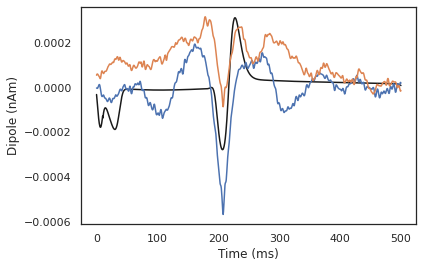

In [51]:
plt.plot(t_vec, x_cond_list[0].squeeze(), color='k')
for x_real in x_real_list:
    plt.plot(t_vec, x_real.squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Dipole (nAm)')